In [6]:
from __future__ import annotations

import json
from pathlib import Path
from typing import TypedDict, List, Dict, Any

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# Paths
ROOT = Path(".").resolve()
DATA = ROOT / "data"
DATA.mkdir(exist_ok=True)
POLICY_JSON = DATA / "policies.json"
INDEX_DIR = DATA / "policy_faiss_index2"
INDEX_DIR.mkdir(exist_ok=True)


In [7]:
# You can replace/extend this with your real content
seed_policies: Dict[str, Dict[str, str]] = {
    "HR": {
        "Leave and Attendance": (
            "Employees are entitled to 20 days of casual leave per calendar year. "
            "Casual leave must be applied for in advance where possible. Unused casual leave "
            "cannot be carried forward to the next year."
        ),
        "Sick Leave": (
            "Employees are granted 10 days of paid sick leave annually. Absences beyond three "
            "consecutive working days require a medical certificate."
        ),
    },
    "Finance": {
        "Reimbursement Claims": (
            "All reimbursement claims must be submitted within 30 days of expense. "
            "Valid receipts are mandatory. Late claims require Finance Manager approval."
        ),
        "Travel Advance": (
            "Travel advance may be requested for trips exceeding two days. Settlement is due "
            "within 15 days after trip completion."
        ),
    },
    "IT": {
        "Password Reset": (
            "If you forgot your password or suspect a breach, raise a ticket on the IT helpdesk portal. "
            "You will receive a temporary password by email and must change it within 24 hours."
        ),
        "Email Access": (
            "Company email is for official use. Access from external devices requires prior approval "
            "from IT security."
        ),
    },
}

# Write to a JSON file (idempotent)
with open(POLICY_JSON, "w", encoding="utf-8") as f:
    json.dump(seed_policies, f, indent=2, ensure_ascii=False)

print("✅ Wrote seed policies to", POLICY_JSON)


✅ Wrote seed policies to C:\Users\sanat\LangGraph-Udemy-Course\LangGraphDHS\data\policies.json


In [8]:
def build_faiss_from_policies(json_path: Path, index_dir: Path) -> None:
    with open(json_path, "r", encoding="utf-8") as f:
        policies = json.load(f)

    docs: List[Document] = []
    for dept, topics in policies.items():
        for topic, text in topics.items():
            docs.append(
                Document(
                    page_content=text,
                    metadata={"department": dept, "topic": topic}
                )
            )

    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
    chunks = splitter.split_documents(docs)

    embeddings = OpenAIEmbeddings()
    vs = FAISS.from_documents(chunks, embeddings)
    vs.save_local(str(index_dir))
    print(f"✅ FAISS index written to {index_dir}")

# Build if missing
if not (INDEX_DIR / "index2.faiss").exists() or not (INDEX_DIR / "index2.pkl").exists():
    build_faiss_from_policies(POLICY_JSON, INDEX_DIR)
else:
    print("ℹ️ Using existing FAISS index at", INDEX_DIR)


✅ FAISS index written to C:\Users\sanat\LangGraph-Udemy-Course\LangGraphDHS\data\policy_faiss_index2


In [9]:
class HelpdeskState(TypedDict, total=False):
    messages: List[Any]
    department: str
    retrieved_docs: List[Document] | List[str]
    final_answer: str

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.3)
emb = OpenAIEmbeddings()
vectorstore = FAISS.load_local(
    str(INDEX_DIR), emb, index_name="index", allow_dangerous_deserialization=True
)

def _last_content(state: HelpdeskState) -> str:
    m = state["messages"][-1]
    return m["content"] if isinstance(m, dict) else getattr(m, "content", str(m))


In [10]:
def classify_department(state: HelpdeskState) -> HelpdeskState:
    query = _last_content(state)
    prompt = PromptTemplate.from_template(
        """Classify the user query into one of: HR, Finance, IT.
Return ONLY one token: HR, Finance, or IT.

Query: {query}"""
    )
    dept = LLMChain(llm=llm, prompt=prompt).run(query=query).strip()
    dept_norm = dept.upper()
    if dept_norm not in {"HR", "FINANCE", "IT"}:
        # Fallback: try a simple heuristic before defaulting to HR
        if any(k in query.lower() for k in ["reimburse", "invoice", "expense", "claim"]):
            dept_norm = "FINANCE"
        elif any(k in query.lower() for k in ["password", "vpn", "email", "laptop", "it "]):
            dept_norm = "IT"
        else:
            dept_norm = "HR"
    return {**state, "department": dept_norm}


In [11]:
def retrieve_policies(state: HelpdeskState) -> HelpdeskState:
    query = _last_content(state)
    dept = state.get("department")
    retriever = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={"k": 6, "lambda_mult": 0.2},
    )
    # Pull and then filter by department metadata
    docs = retriever.get_relevant_documents(query) or []
    if dept in {"HR", "FINANCE", "IT"}:
        docs = [d for d in docs if d.metadata.get("department", "").upper() == dept]
    return {**state, "retrieved_docs": docs}


In [12]:
def filter_policies(state: HelpdeskState) -> HelpdeskState:
    docs: List[Document] = state.get("retrieved_docs", [])
    if not docs:
        return {**state, "retrieved_docs": []}
    query = _last_content(state)
    combined = "\n\n---\n\n".join(
        [f"[{d.metadata.get('department','?')}/{d.metadata.get('topic','?')}]\n{d.page_content}" for d in docs]
    )
    prompt = PromptTemplate.from_template(
        """You are filtering policy excerpts for the user's question.

Question:
{query}

Excerpts:
{docs}

Keep ONLY the minimal set of excerpts that directly answer the question.
- Drop anything irrelevant to the question.
- Do NOT add new information.
Return the kept excerpts VERBATIM, joined by two newlines.
If nothing helps, return exactly: NO_MATCH
"""
    )
    filtered = LLMChain(llm=llm, prompt=prompt).run(query=query, docs=combined).strip()
    kept = [] if filtered == "NO_MATCH" or not filtered else [filtered]
    return {**state, "retrieved_docs": kept}


In [13]:
def answer_from_policies(state: HelpdeskState) -> HelpdeskState:
    content = state.get("retrieved_docs", [])
    query = _last_content(state)
    if not content:
        return {**state, "final_answer": "Sorry, I couldn’t find a relevant policy excerpt for that."}

    prompt = PromptTemplate.from_template(
        """Based ONLY on the excerpts below, answer the user's question clearly.
If the excerpts do not contain the answer, say you don’t have enough info.

Question:
{query}

Excerpts:
{content}

Rules:
- Do not invent details beyond the excerpts.
- If numbers/limits aren’t present, do NOT guess them.
- Keep it short (3–5 sentences)."""
    )
    final = LLMChain(llm=llm, prompt=prompt).run(query=query, content=content[0]).strip()
    return {**state, "final_answer": final}


In [18]:
builder = StateGraph(HelpdeskState)

# Nodes (agents)
builder.add_node("ClassifyDepartment", classify_department)
builder.add_node("RetrievePolicies",   retrieve_policies)
builder.add_node("FilterPolicies",     filter_policies)
builder.add_node("Answer",             answer_from_policies)

# Entry → flow → END
builder.set_entry_point("ClassifyDepartment")
builder.add_edge("ClassifyDepartment", "RetrievePolicies")
builder.add_edge("RetrievePolicies",   "FilterPolicies")
builder.add_edge("FilterPolicies",     "Answer")
builder.add_edge("Answer",             END)

graph2 = builder.compile()
print("✅ Graph compiled")


✅ Graph compiled


In [15]:
def run_query(query: str, debug: bool = True):
    input_state: HelpdeskState = {"messages": [HumanMessage(content=query)]}
    result = graph.invoke(input_state)

    if debug:
        print("—" * 60)
        print("Dept:", result.get("department"))
        # If we want to re-run raw retrieval to inspect:
        dept = result.get("department")
        retriever = vectorstore.as_retriever(
            search_type="mmr",
            search_kwargs={"k": 4, "lambda_mult": 0.2},
        )
        raw = retriever.get_relevant_documents(query) or []
        raw = [d for d in raw if d.metadata.get("department","").upper() == dept]
        print("\nTop retrieved (pre-filter):")
        for i, d in enumerate(raw, 1):
            print(f"\n[{i}] {d.metadata.get('department')}/{d.metadata.get('topic')}")
            print(d.page_content[:300], "…")

        kept = result.get("retrieved_docs", [])
        if kept:
            print("\nKept excerpts (post-filter):\n", kept[0][:800], "…")
        else:
            print("\nKept excerpts (post-filter): <none>")

        print("\n✅ Final Answer:\n", result.get("final_answer"))

    return result


In [23]:
# run_query("How to reset IT password?")
run_query("How many casual leaves can I take in a year?")
# run_query("is personal travel expenses covered under travel policy?")


————————————————————————————————————————————————————————————
Dept: HR

Top retrieved (pre-filter):

[1] HR/Leave and Attendance
Employees are entitled to 20 days of casual leave per calendar year. Casual leave must be applied for in advance where possible. Unused casual leave cannot be carried forward to the next year. …

Kept excerpts (post-filter):
 [HR/Leave and Attendance]
Employees are entitled to 20 days of casual leave per calendar year. Casual leave must be applied for in advance where possible. Unused casual leave cannot be carried forward to the next year. …

✅ Final Answer:
 You are entitled to 20 days of casual leave per calendar year. Casual leave must be applied for in advance where possible. Unused casual leave cannot be carried forward to the next year.


{'messages': [HumanMessage(content='How many casual leaves can I take in a year?', additional_kwargs={}, response_metadata={})],
 'department': 'HR',
 'retrieved_docs': ['[HR/Leave and Attendance]\nEmployees are entitled to 20 days of casual leave per calendar year. Casual leave must be applied for in advance where possible. Unused casual leave cannot be carried forward to the next year.'],
 'final_answer': 'You are entitled to 20 days of casual leave per calendar year. Casual leave must be applied for in advance where possible. Unused casual leave cannot be carried forward to the next year.'}

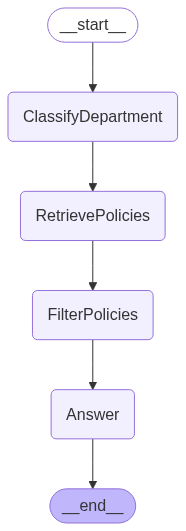

In [20]:
try:
    from IPython.display import Image, display
    display(Image(graph2.get_graph().draw_mermaid_png()))
except Exception:
    print(graph2.get_graph().draw_mermaid())  # Paste into mermaid.live if needed
